In [ ]:
import sys
from awsglue.dynamicframe import DynamicFrame
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from pyspark.sql.functions import *
from awsglue.context import GlueContext
from awsglue.job import Job

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sc = SparkContext.getOrCreate()
glueContext = GlueContext(sc)
spark = glueContext.spark_session
job = Job(glueContext)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# s3 buckets for data preprocessing
masterpath = 's3://finalproject-analytics/Master_dataset.parquet/'
gmpath = 's3://finalproject-analytics/GrandMaster_dataset.parquet/'
cpath = 's3://finalproject-analytics/Challenger_dataset.parquet/'

In [ ]:
# creating pandas dataframe
mdata = pd.read_parquet(masterpath, engine='pyarrow')
gmdata = pd.read_parquet(gmpath, engine='pyarrow')
cdata = pd.read_parquet(cpath,engine='pyarrow')

In [ ]:
# assigning a new column to each dataframe with their respective Rank
mdata = mdata.assign(Rank = 'Master')
cdata = cdata.assign(Rank = 'Challenger')
gmdata = gmdata.assign(Rank = 'Grandmaster')

In [ ]:
# merging all the dataframes into one
merged_data = pd.concat([mdata,gmdata,cdata])

In [ ]:
merged_data

,gameId,gameDuraton,blueWins,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,...,redChampionDamageDealt,redTotalGold,redTotalMinionKills,redTotalLevel,redAvgLevel,redJungleMinionKills,redKillingSpree,redTotalHeal,redObjectDamageDealt,Rank
0,4227123625,1429,0,1,1,0,0,0,0,0,...,53831,41991,609,64,12.8,127,4,12916,26338,Master
1,4219545724,1313,0,0,1,0,0,0,0,0,...,52924,39672,510,63,12.6,133,4,12252,29828,Master
2,4219463634,1660,1,0,0,1,1,1,1,1,...,61745,46516,630,65,13.0,153,2,17005,37066,Master
3,4205778093,984,1,1,1,0,1,0,2,0,...,25007,21444,304,41,8.2,51,1,10499,3085,Master
4,4201063474,1437,0,1,1,0,1,0,2,0,...,71794,45798,565,68,13.6,150,7,47523,47150,Master
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26899,4143231833,1468,0,1,0,0,0,0,1,0,...,75531,46558,478,64,12.8,141,6,48596,42733,Challenger
26900,4157911901,970,0,1,1,0,1,0,3,0,...,99837,70177,455,72,14.4,136,11,15817,50217,Challenger
26901,3764171638,1480,0,1,1,0,1,0,1,0,...,55214,48849,636,66,13.2,175,6,25448,27675,Challenger
26902,4110201724,1837,1,1,0,0,1,0,3,0,...,88366,52625,660,70,14.0,168,5,25003,45455,Challenger


In [ ]:
# checking if data has successfully merged
# by checking the location of the
# second gameId of each Rank
merged_data.loc[1,:]

,gameId,gameDuraton,blueWins,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,...,redChampionDamageDealt,redTotalGold,redTotalMinionKills,redTotalLevel,redAvgLevel,redJungleMinionKills,redKillingSpree,redTotalHeal,redObjectDamageDealt,Rank
1,4219545724,1313,0,0,1,0,0,0,0,0,...,52924,39672,510,63,12.6,133,4,12252,29828,Master
1,4233222221,1686,0,0,1,0,0,0,0,0,...,78424,58032,640,73,14.6,214,5,31415,61040,Grandmaster
1,4247155821,1317,1,0,0,0,1,0,2,0,...,44218,37136,571,59,11.8,134,3,24829,14105,Challenger


In [ ]:
# doubling checking with the length = 199925
len(merged_data.index)

199925

In [ ]:
# Creating a list of Ranks to filter the gamesId
ranks = ['Challenger', 'Grandmaster', 'Master']
rank_counts = merged_data['Rank'].value_counts()
rank_counts

Master         107125
Grandmaster     65896
Challenger      26904
Name: Rank, dtype: int64

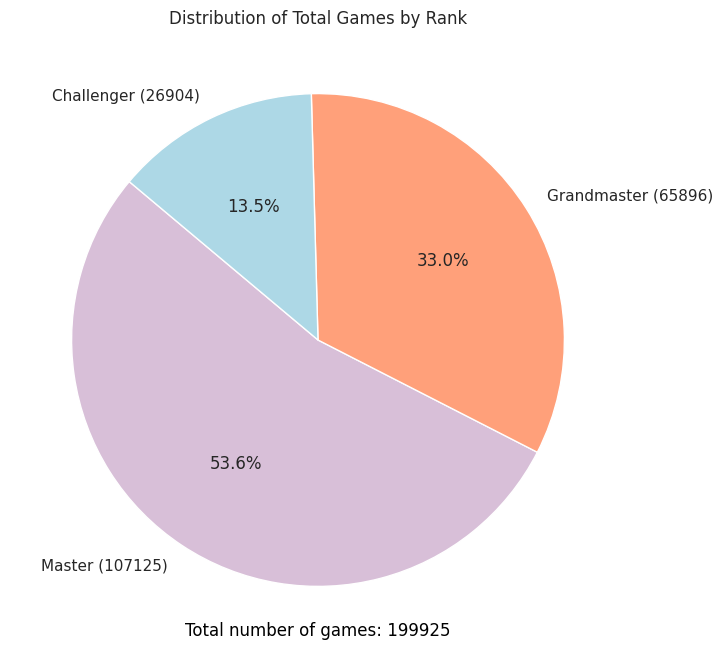

In [ ]:
# Pie chart of total ranked games split by ranks
rank_counts = merged_data['Rank'].value_counts()

lighter_colors = {
    'Challenger': '#ADD8E6',  # Blue
    'Grandmaster': '#FFA07A',  # Red
    'Master': '#D8BFD8'  # Purple
}

plt.figure(figsize=(8, 8))
plt.pie(rank_counts, labels=[f"{rank} ({count})" for rank, count in zip(rank_counts.index, rank_counts)],
        autopct='%1.1f%%', colors=[lighter_colors[rank] for rank in rank_counts.index], startangle=140)
plt.title("Distribution of Total Games by Rank")
plt.text(0, -1.2, f"Total number of games: {rank_counts.sum()}", ha='center', fontsize=12, color='black')
plt.show()

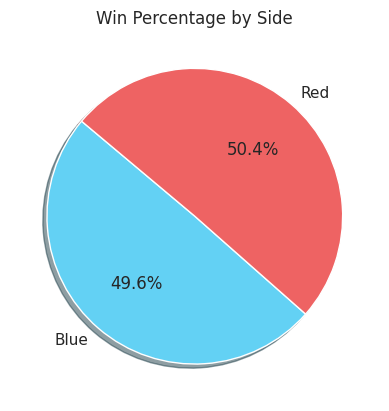

In [ ]:
#  Win Percentage by Side
labels = ['Blue', 'Red']
sizes = [merged_data['blueWins'].mean(),  merged_data['redWins'].mean()]
colors = ['#63D1F4', '#EE6363']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        colors=colors, shadow=True, startangle=140)
plt.title("Win Percentage by Side")
plt.show()

Average game length: 23.89 minutes


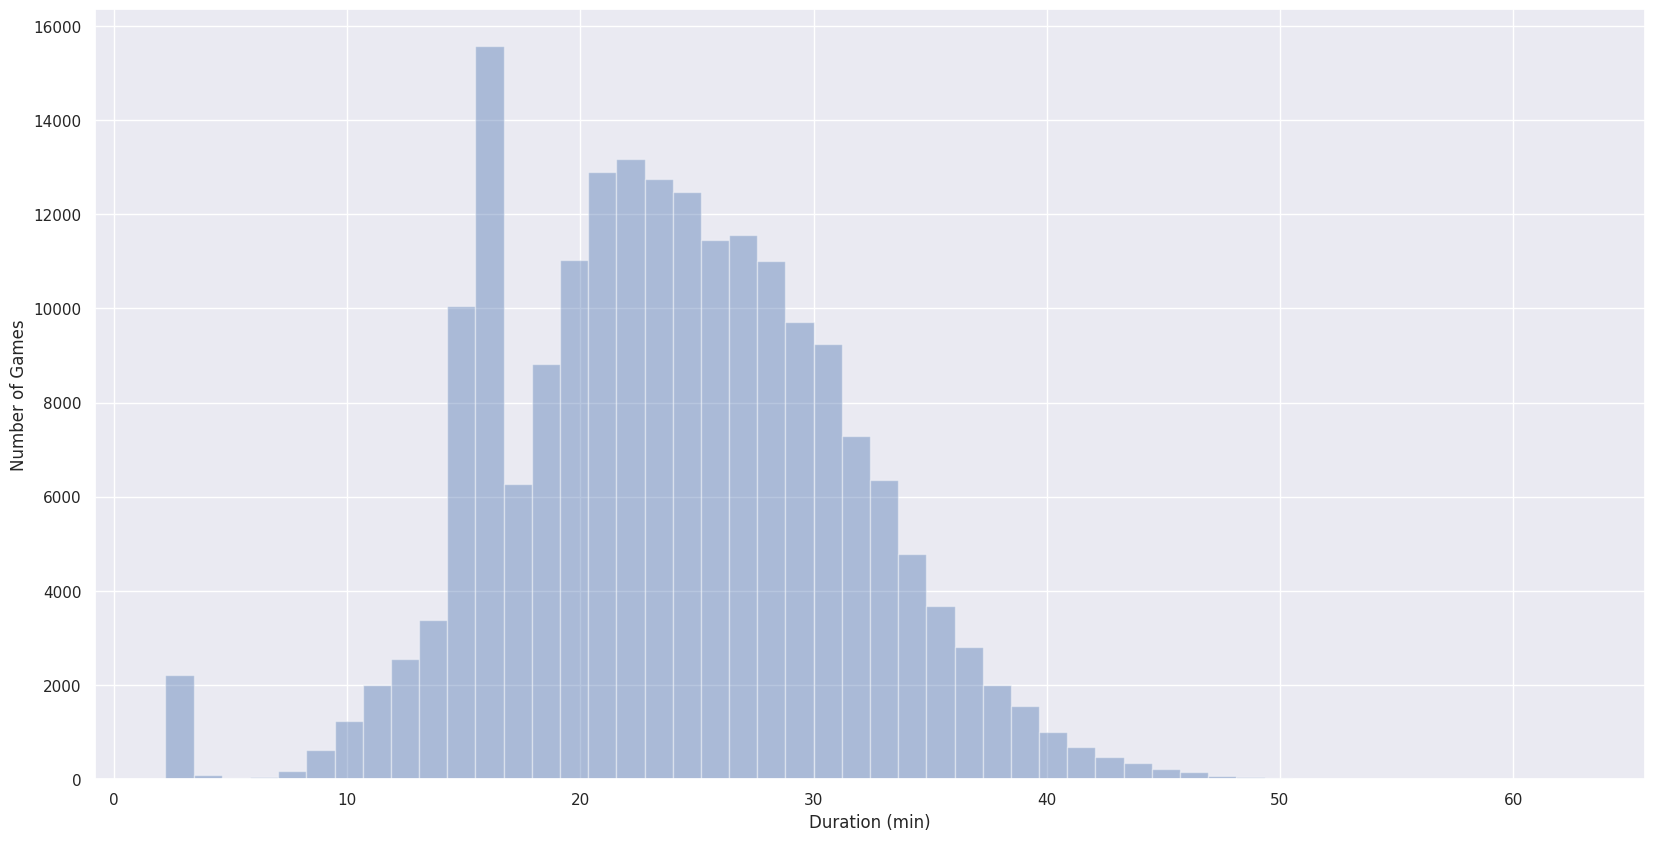

In [ ]:
# Average Game Length
print("Average game length: {:.2f} minutes".format(merged_data['gameDuraton'].mean()/60))
plt.figure(figsize=(20,10))
sns.distplot(merged_data['gameDuraton']/60, hist=True, kde=False)
sns.set(font_scale = 2)
plt.xlabel('Duration (min)')
plt.ylabel('Number of Games')

plt.show()

In [ ]:
# Blue Side vs Red Side Data Analytics
categories = ['Wins', 'FirstBlood', 'FirstTower',
       'FirstBaron', 'FirstDragon', 'FirstInhibitor',
       'DragonKills', 'BaronKills', 'TowerKills',
       'InhibitorKills', 'WardPlaced', 'Wardkills', 'Kills',
       'Death', 'Assist', 'ChampionDamageDealt', 'TotalGold',
       'TotalMinionKills', 'TotalLevel', 'AvgLevel',
       'JungleMinionKills', 'KillingSpree', 'TotalHeal',
       'ObjectDamageDealt']

blue_percentage_data = {}

for category in categories:
    blue_total = merged_data['blue'+category].sum()
    red_total = merged_data['red'+category].sum()
    total = (blue_total + red_total).sum()

    blue_percent = blue_total/total
    red_percent = red_total/total

    blue_percentage_data[category] = blue_percent

blue_over = {k:v for k,v in blue_percentage_data.items() if (abs(v-0.5)>0.01) or k=="Wins"}
red_over = {k:1-v for k,v in blue_over.items()}

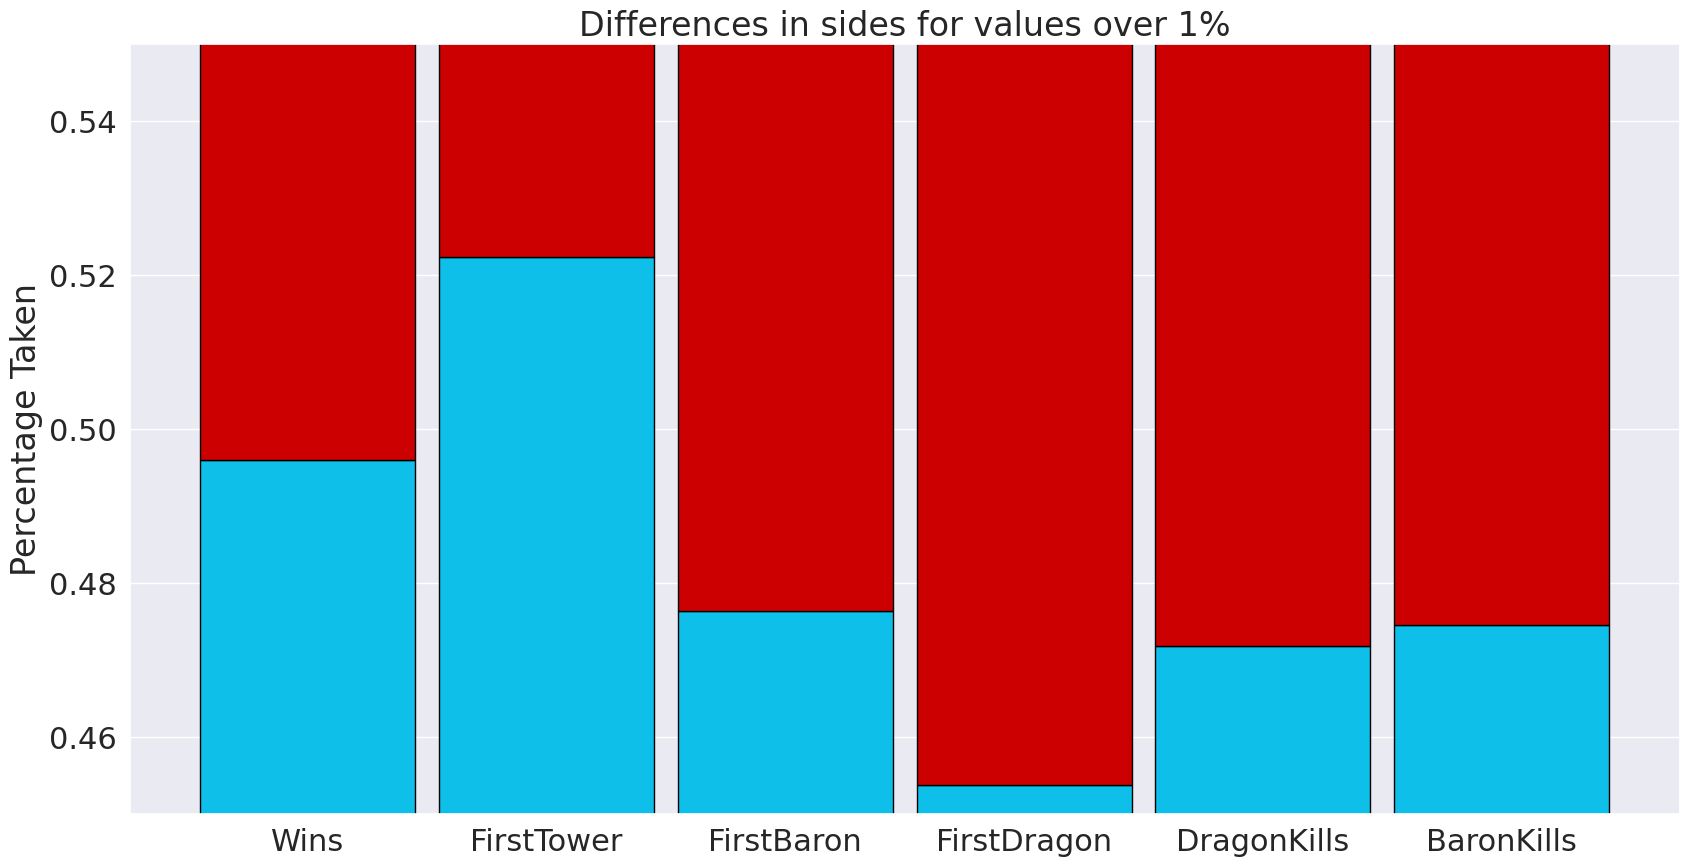

In [ ]:
# Plotting Blue Side vs Red Side
y = range(len(blue_over))
plt.figure(figsize=(20,10))
barWidth = 0.9
# blue
plt.bar(y, list(blue_over.values()), color='#0EBFE9', edgecolor='black', width=barWidth)
# red
plt.bar(y, list(red_over.values()), bottom=list(blue_over.values()), color='#cc0000', edgecolor='black', width=barWidth)

# Custom x axis
plt.xticks(y, blue_over.keys())
plt.ylim((0.45,0.55))
plt.ylabel("Percentage Taken")
plt.title("Differences in sides for values over 1%")
# Show graphic
plt.show()

In [ ]:
# Win Correlations
# pearson method normalizes values for me
blue_corr = merged_data.drop('Rank', axis=1).corr()['blueWins'][:].sort_values(axis=0, ascending=False)
blue_corr.head()


blueWins                 1.000000
blueTowerKills           0.717463
blueFirstInhibitor       0.658354
blueInhibitorKills       0.574076
blueObjectDamageDealt    0.522638
Name: blueWins, dtype: float64

In [ ]:
red_corr = merged_data.drop('Rank', axis=1).corr()['redWins'][:].sort_values(axis=0, ascending=False)
red_corr.head()

redWins                 1.000000
redTowerKills           0.722430
redFirstInhibitor       0.645034
redInhibitorKills       0.569259
redObjectDamageDealt    0.551108
Name: redWins, dtype: float64

<Axes: >

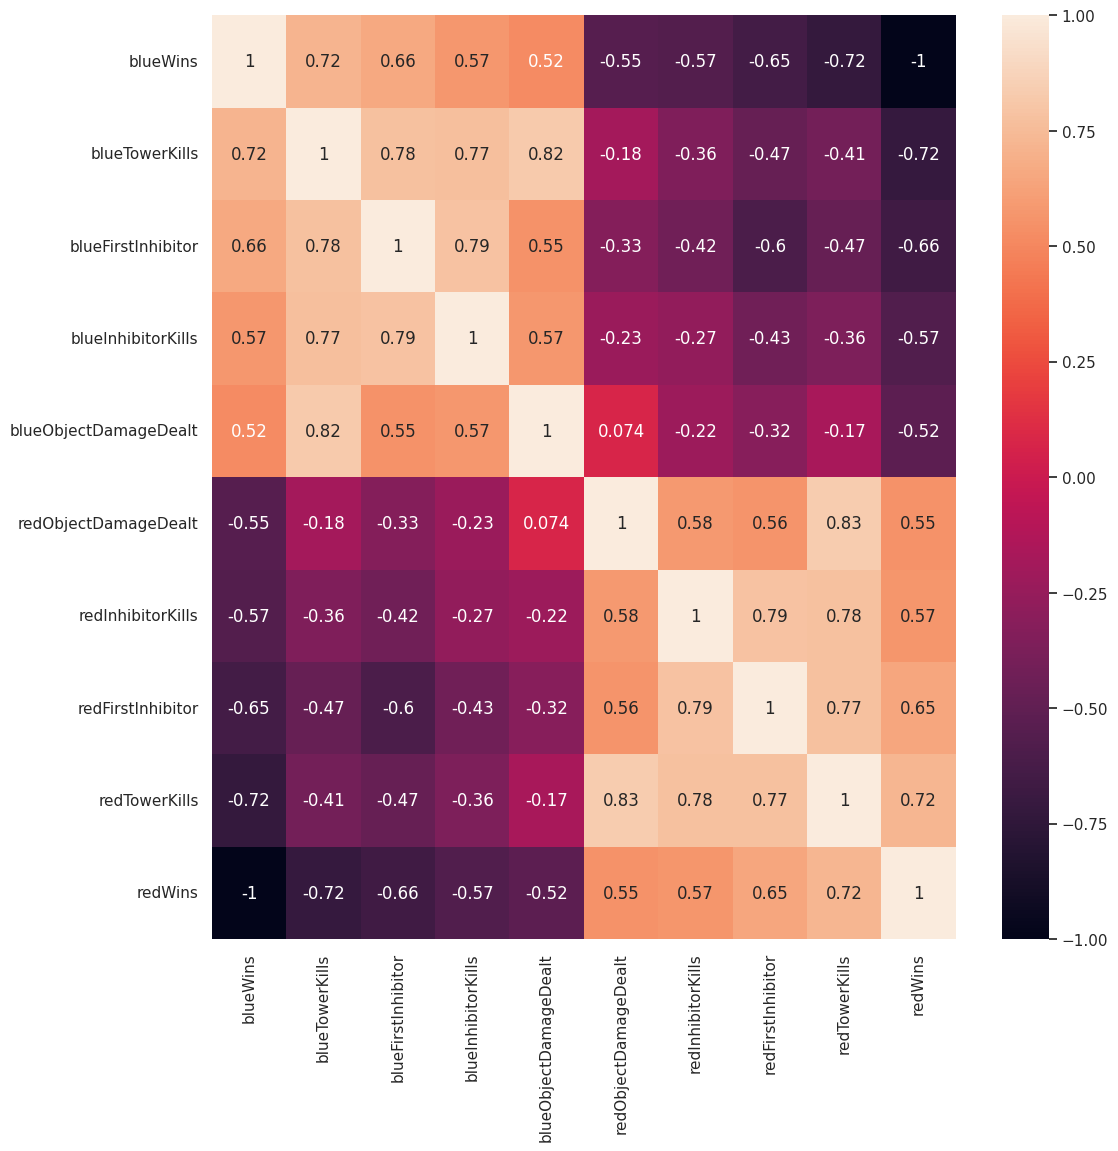

In [ ]:
# get correlations of 0.5 or more
corr_cols = [prop for prop, corr in blue_corr.items() if abs(corr) > 0.5]
plt.figure(figsize=(12, 12))
sns.set(font_scale=1)
sns.heatmap(merged_data[corr_cols].corr(), annot=True)

<Axes: >

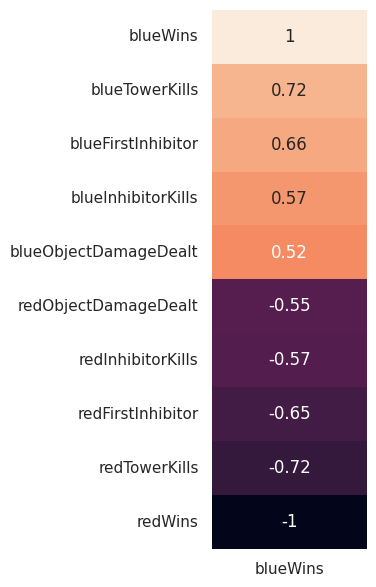

In [ ]:
# Blue wins to any correlation above 0.5
plt.figure(figsize=(2,7))
sns.heatmap(blue_corr[corr_cols].to_frame(), annot=True, cbar=False)

<Axes: >

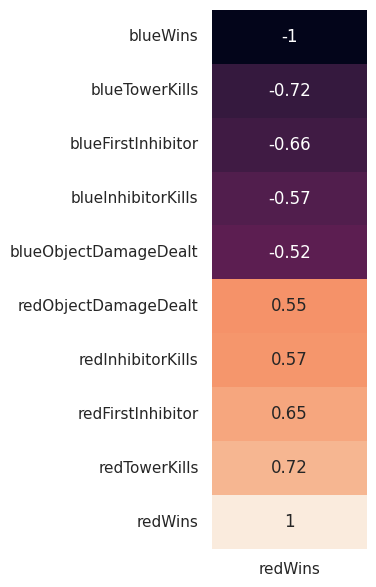

In [ ]:
# Red wins to any correlation above 0.5
plt.figure(figsize=(2,7))
sns.heatmap(red_corr[corr_cols].to_frame(), annot=True, cbar=False)

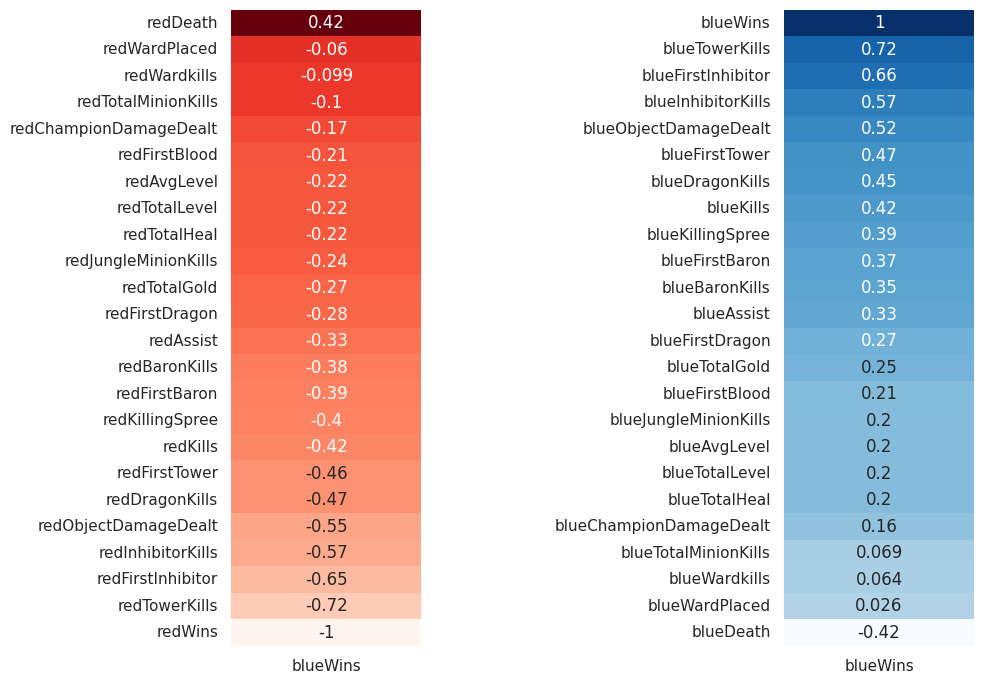

<Figure size 200x700 with 0 Axes>

<Figure size 200x700 with 0 Axes>

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(10, 7))

# Plot for 'red' correlations
plt.figure(figsize=(2, 7))
red_corra = [prop for prop, corr in blue_corr.items() if 'red' in prop]
sns.heatmap(blue_corr[red_corra].sort_values(axis=0, ascending=False).to_frame(), annot=True, cbar=False, ax=axes[0], cmap='Reds')

# Plot for 'blue' correlations
plt.figure(figsize=(2, 7))
blue_corra = [prop for prop, corr in blue_corr.items() if 'blue' in prop]
sns.heatmap(blue_corr[blue_corra].to_frame(), annot=True, cbar=False, ax=axes[1], cmap='Blues')

f.tight_layout(w_pad=8)

plt.show()